In [1]:
import numpy as np
from pydub.playback import play
from pydub import AudioSegment
import os
import pylab
import wave
import IPython
from td_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\jennings mcenroe\appdata\local\programs\python\python35\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\users\jennings mcenroe\appdata\local\programs\python\python35\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [2]:
#reading the audio files 
negative_files = os.listdir("./custom_sample/negatives")
elita_files = os.listdir("./custom_sample/elita")
background_files = os.listdir("./custom_sample/background")
negatives = []
elitas = []
background = []
background_new=[]
for i in negative_files:
    negatives.append(AudioSegment.from_wav("./custom_sample/negatives/"+i))
for i in elita_files:
    elitas.append(AudioSegment.from_wav("./custom_sample/elita/"+i))    
for i in background_files: 
    background.append(AudioSegment.from_wav("./custom_sample/background/"+i))
for i in range(len(background)):
    background_new.append(background[i][:10000])

In [5]:
len(background_new[0])

10000

In [3]:
#constants
Tx=1998
Ty = 497
n_freq = 101 

In [4]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [5]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [6]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###


In [7]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [8]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [22]:
def create_training_example(background, activates, negatives,num):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    #np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("./waves1/train_jennings" +str(num)+ ".wav", format="wav")
    #print("File (train_jennings.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("./waves1/train_jennings" +str(num)+ ".wav")
    
    return x, y

c:\users\663860\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:7172: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Finished


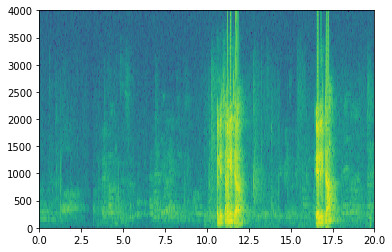

In [19]:
X_data = []
Y_data = []
for i in range(500):
    b =  np.random.randint(15)
    x, y =  create_training_example(background_new[b], elitas, negatives,i)
    x = np.swapaxes(x,0,1)
    y = np.swapaxes(y,0,1)
    X_data.append(x)
    X = np.array(X_data)
    Y_data.append(y)
    Y = np.array(Y_data)
print("Finished")

In [20]:
# for i in range(500,1000):
#     b =  np.random.randint(15)
#     x, y =  create_training_example(background_new[b], elitas, negatives,i)
#     x = np.swapaxes(x,0,1)
#     y = np.swapaxes(y,0,1)
#     X_data.append(x)
#     X = np.array(X_data)
#     Y_data.append(y)
#     Y = np.array(Y_data)

In [21]:
with open('./custom_data/XY_train/X.npy', 'wb') as x_file:
    np.save(x_file, X)
with open('./custom_data/XY_train/Y.npy', 'wb') as y_file:
    np.save(y_file, Y)

c:\users\663860\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:7172: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Finished


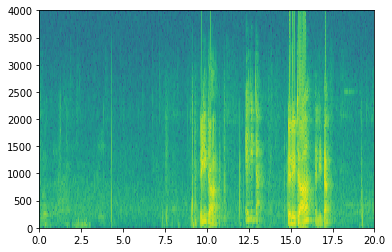

In [23]:
X_data = []
Y_data = []
for i in range(50):
    b =  np.random.randint(15)
    x, y =  create_training_example(background_new[b], elitas, negatives,i)
    x = np.swapaxes(x,0,1)
    y = np.swapaxes(y,0,1)
    X_data.append(x)
    X = np.array(X_data)
    Y_data.append(y)
    Y = np.array(Y_data)
print("Finished")

In [24]:
with open('./custom_data/XY_dev/X.npy', 'wb') as x_file:
    np.save(x_file, X)
with open('./custom_data/XY_dev/Y.npy', 'wb') as y_file:
    np.save(y_file, Y)

In [26]:
X.shape

(50, 1998, 101)